In [59]:
# Python graphs: https://python-graph-gallery.com/
# Visualization with matplotlib: https://www.oreilly.com/library/view/python-data-science/9781491912126/ch04.htmlimport matplotlib.pyplot as plt
import os
from datetime import datetime, timedelta
from pprint import pprint

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from matplotlib.offsetbox import AnchoredText
from scipy.ndimage.filters import gaussian_filter1d


def plot_vehicle_status_graph(
        instances_folder,
        result_folder,
        name_experiment,
        replace=True,
        smooth=None,
        print_details=True,
        fontsize='small',
        fontsize_label='small',
        show_tick_label_x=False,
        label_y=(None, None, 'small'),
        horizontal_legend=False,
        fig_type='png',
        custom_tw=(None, None),
        day_sep_config=(None, None),
        size_inches=(18, 3),
        nbins_y=5,
        x_data_format=('1h', '%H'),
        color_bg="#FFE4E1",
        context_font_scale=1,
        print_details_axis=(None, None),
        input_dic=None,
        show_week_days=False,
        show_day_separator=True,
        linewidth=1.5,
        tick_length=3,
        show_service_rate="Service rate: ",
        fontsize_label_sr='large',
        msg=None,
        annotate_data_per_status=False,
        extra_info_coord = '2019-02-20 06:30:00'):
    # Create directory
    if not os.path.exists(result_folder):
        os.makedirs(result_folder)

    # Save path
    name_fig = "{}{}.{}".format(result_folder, "VS_" + name_experiment, fig_type)

    # Stop generation if already generated
    if os.path.isfile(name_fig) and not replace:
        return

    print("Creating figure in '{}'".format(name_fig))

    # Get experiment data
    if input_dic:
        srate_dict = {'S1': 'High', 'S2': 'Moderate', 'S3': 'Low'}
        fleet_size = int(input_dic["max_capacity"])
        v_cap = int(input_dic["max_capacity"])
        th = int(input_dic["simulation_time"])
        tw = int(input_dic["batch_duration"])
        cs = input_dic["customer_segmentation"]
        sr = input_dic.get("service_rate", "NA")

        # Standard data frequency
    # E.g., freq = {10min, 6h, 1d}, format = {'%H:%M', '%H'}
    x_freq, x_format = x_data_format

    # Get custom time window (.e.g., ('2011-02-01T00:00:00', '2011-02-06T00:00:00'))
    custom_tw_min, custom_tw_max = custom_tw
    print(f"TW1({custom_tw_min}, {custom_tw_max})")

    print("TW:", custom_tw)
    # X series (dates)
    x_min = datetime.strptime(custom_tw_min, '%Y-%m-%dT%H:%M:%S')
    x_max = datetime.strptime(custom_tw_max, '%Y-%m-%dT%H:%M:%S')

    print(f"TW2({custom_tw_min}, {custom_tw_max})")

    x_start = x_min + timedelta(seconds=tw)
    x_end = x_max + timedelta(seconds=tw)

    x_last_req = x_min + timedelta(seconds=th) + timedelta(seconds=tw)

    range_dates = pd.date_range(start=x_start,
                                end=x_end,
                                freq=x_freq)

    # range_dates_label = [str(int(d.strftime(x_format))) for d in range_dates]
    range_dates_label = [str(d.strftime(x_format)) for d in range_dates]
    # range_dates_label = [str(int(d.strftime(config[th]['format'])))+'h' for d in range_dates]

    # Load results
    df = pd.read_csv("{}{}.csv".format(instances_folder, name_experiment),
                     index_col="timeStepDateTime",
                     parse_dates=True,
                     comment="#")

    print(df.columns)
    print("Firt record:", df.iloc[0].name, " -- Last record:", df.iloc[-1].name)

    print("TW:", x_min, x_max)

#     # Number of requests
#     total_requests = df["n_requests"].sum()
#     time_ride_matching_s = df["time_ride_matching_s"].sum()
#     time_update_fleet_status_s = df["time_update_fleet_status_s"].sum()
#     time_vehicle_rebalancing_s = df["time_vehicle_rebalancing_s"].sum()

#     total_runtime = time_ride_matching_s + time_vehicle_rebalancing_s + time_vehicle_rebalancing_s
#     serviced = df["finished"][-1]
#     denied = df["denied"][-1]

    df.rename(columns={'nOfVehicles':'',
              'nOfVehiclesDwellingInOrigin':'origin_vehicles',
              'nOfVehiclesParked':'parked_vehicles',
              'nOfVehiclesRebalancing':'rebalancing',
              'nOfVehiclesServicingUsers': 'servicing',
              'nOfVehiclesCruisingToPickup':'picking_up'}, inplace=True)
 
    label_dict = {
    "nOfVehiclesParked":"parked_vehicles",
    
    }
    # Separate occupancy labels (e.g., O1, O2, O3, etc.)
    occupancy_labels = [col for col in list(df) if 'n_load' in col]
    status_labels = ["parked_vehicles", "rebalancing",
                     "picking_up"] + occupancy_labels  # ["origin_vehicles", "parked_vehicles", "rebalancing", "picking_up"] + occupancy_labels

    # Get fleet makeup
    mark_fleet_makeup = 'n_servicing_capacity_'
    fleet_makeup_labels = [col for col in list(df) if mark_fleet_makeup in col]
    fleet_makeup = {mk: df[mk][-1] for mk in fleet_makeup_labels}
    total_seats = {k: int(k[len(mark_fleet_makeup):]) * v for k, v in fleet_makeup.items()}

    # Filter occupancy columns
    df_occupancy = df[occupancy_labels]

    # Build fleet status
    df_status = pd.DataFrame(df_occupancy)
    df_status["picking_up"] = df["picking_up"]
    df_status["rebalancing"] = df["rebalancing"]
    df_status["parked_vehicles"] = df["parked_vehicles"] + df["origin_vehicles"]

    # Smooth values
    df_occupancy = df_occupancy.rolling(window=24).mean()

    # Define axis
    df_filtered = df_status.loc[x_start:x_end]
    x = df_filtered.index.values
    print("Len x:", len(x))

    y = [df_filtered[c].tolist() for c in status_labels]

    # Define limits of y (before smoothing)
    ymin = 0
    ymax = max(y)

    # Smoth lines in y
    if smooth:
        y = gaussian_filter1d(y, sigma=smooth)

    # Get the unique hours within interval()
    hours = set(df_occupancy.index.hour.values)

    # Format legend
    graph_legend = ["Parked", "Rebalancing", "Picking up"] + ["1 passenger", "2 passengers", "3 passengers", "4 passengers"]
    # Choosing palette. Source: https://seaborn.pydata.org/tutorial/color_palettes.html

    sns.set_context('paper')
    sns.set_style("ticks", {"xtick.major.size": 8, "axes.grid": True, 'axes.facecolor': '#d0d0dd', 'grid.color': '1.0'})
    sns.set_context("notebook", font_scale=context_font_scale)
    print(sns.axes_style())

    YlGnBu_r = ['#081d58', '#e31a1c', '#225ea8', '#1d91c0', '#7fcdbb', '#c7e9b4', '#ffffd9']

    sns.set_palette(YlGnBu_r)

    print("Range: ", range_dates)
    plt.xlim(min(x), range_dates[-1])

    ticks_x = []
    if show_tick_label_x:
        ticks_x = range_dates_label

    l_y, t_y, fontsize = label_y

    if l_y is not None:
        plt.yticks(l_y, t_y, fontsize=fontsize)
        plt.ylim(l_y[0], l_y[-1])
        print("LIMITS:", l_y[0], l_y[-1])
    else:
        plt.yticks(fontsize=fontsize)
        plt.locator_params(axis='y', nbins=nbins_y)

    plt.xticks(range_dates, ticks_x, fontsize=fontsize)

    # https://matplotlib.org/api/axis_api.html#matplotlib.axis.Axis.set_tick_params
    ax = plt.gca()
    t_width = linewidth
    ax.tick_params(width=t_width, length=tick_length)
    ax.spines['top'].set_linewidth(t_width)
    ax.spines['right'].set_linewidth(t_width)
    ax.spines['bottom'].set_linewidth(t_width)
    ax.spines['left'].set_linewidth(t_width)

    # Print x, y axis labels
    det_x, det_y = print_details_axis
    if det_x:
        plt.xlabel(det_x, fontweight='bold', fontsize=fontsize_label)
    if det_y:
        plt.ylabel(det_y, fontweight='bold', fontsize=fontsize_label)

    if print_details:

        # Position legend (Source: https://matplotlib.org/api/legend_api.html?highlight=legend#module-matplotlib.legend)
        legend = None
        # https://pythonspot.com/matplotlib-legend/
        if horizontal_legend:
            legend = plt.legend(loc="upper center",
                                bbox_to_anchor=(0.5, -0.1),
                                ncol=len(graph_legend),
                                fontsize=fontsize,
                                edgecolor="white",
                                title="Vehicle status:")
        else:
            legend = plt.legend(loc="upper left",
                                bbox_to_anchor=(1, 1),
                                ncol=1,
                                fontsize=fontsize,
                                edgecolor="white",
                                title="Vehicle status:")

        legend.get_title().set_fontsize(fontsize_label)  # legend 'Title' fontsize


    ########################################################################
    # Inserting data labels ################################################

    # x position
    x_label = datetime.strptime(extra_info_coord, '%Y-%m-%d %H:%M:%S')
    val = [(sq_class, df_filtered.loc[extra_info_coord][sq_class]) for sq_class in status_labels]

    y_pos_labels = []
    previous = 0
    total = 0
    for status, v in val:
        total += v
        y_pos_labels.append((previous, v // 2 + previous, previous + v, v, status))
        previous = previous + v
        print(status, previous, v, total)
        
    y_pos_labels.append((previous, v // 2 + previous, previous + v, total, 'total'))
    
    print("y_pos_labels=", y_pos_labels)
    
    bar = []
    bottom = 0
    width_bar = 0.02

    if annotate_data_per_status:
        print("Data per status:")
        pprint(y_pos_labels)
        left = True
        color_line = 'blueviolet'
        for l, m, r, label, status in y_pos_labels:
            # bar.append(label)

            # ax.annotate(label, xy=(extra_info_coord, m-10), facecolor='red', alpha=0.5, edgecolor='red', textcoords='data', zorder= 1001)
            #         t = plt.text(x_label + timedelta(minutes=60), m, label, bbox=dict(boxstyle='square,pad=0.1',
            #                            alpha=0.8,
            #                            fc='white',
            #                            ec='none'),
            #                     zorder= 1001)
            if left == True:
                x_pos_tag = x_label + timedelta(minutes=60)
                side = ((x_label + timedelta(minutes=120), m))
            #             left = not left
            #         else:
            #             x_pos_tag = x_label - timedelta(minutes=60)
            #             side = ((x_label - timedelta(minutes=120) - timedelta(minutes=240), m))
            #             left = not left

            # print(left, side)
            print(side, (x_label, m + 30))
            ax.annotate("{} {}".format(label, status), xy=(x_label, m + 30),
                        xytext=side,
                        bbox=dict(
                            boxstyle='square,pad=0.1',
                            alpha=0.8,
                            fc='white',
                            ec='none'),
                        textcoords='data',
                        zorder=1001)  # ,
            # arrowprops=dict(arrowstyle='-', color='violet', linewidth=1))
            # arrowprops=dict(arrowstyle='->'), xytext=(15, -10)
            # t.set_bbox(dict(facecolor='red', alpha=0.5, edgecolor='red'))
            # plt.plot([x_label, x_label], [l,r], '-', linewidth=6, markersize=6, marker = "s", zorder= 2000)
            plt.plot([x_label, x_label], [l, r], linewidth=1, zorder=2000, markersize=6, marker="_", color=color_line)

            # plt.bar([x_label], (label,), width_bar, bottom = (bottom,), linewidth=0, zorder= 1000)
            # bottom += label

        # plt.axvline(x= x_label, linewidth=1, color='black', alpha=1)

    if show_day_separator:
        # Print day separator
        back_day_sep_dic, front_day_sep_dic = day_sep_config

        # Day of the week line separator
        dashed_line = x_min

        for i in range(0, 6):

            # Print day separator
            dashed_line = dashed_line + timedelta(hours=24)

            # if dashed_line != x_label:
            if back_day_sep_dic:
                back_day_sep_dic["x"] = dashed_line
                # White box below dashed line for constrast
                plt.axvline(**back_day_sep_dic)

            if front_day_sep_dic:
                front_day_sep_dic["x"] = dashed_line
                # Dashed line to separate week days
                plt.axvline(**front_day_sep_dic)

    # Remove white margins
    plt.margins(0, 0)

    # PRINT SERVICE RATE
    # String format - https://docs.python.org/2/library/string.html#formatstrings
    # font - https://matplotlib.org/gallery/text_labels_and_annotations/fonts_demo_kw.html
    # size - {size in points, 'xx-small', 'x-small', 'small', 'medium', 'large', 'x-large', 'xx-large'}

#     if show_service_rate is not None:
#         sr_pos_x = x_max
#         sr_pos_y = t_y[-1]
#         text = "{}{: >7.2%}".format(show_service_rate, serviced / total_requests)

#         at = AnchoredText(text,
#                           prop=dict(fontstyle='italic',
#                                     fontsize=fontsize_label_sr,
#                                     transform=ax.transAxes,
#                                     bbox=dict(boxstyle='square,pad=0.1',
#                                               alpha=0.6,
#                                               fc='white',
#                                               ec='none')), frameon=True, loc='upper right', pad=0.0, borderpad=0.3)

#         at.patch.set_boxstyle("square,pad=0.0")
#         at.patch.set_ec('none')
#         at.patch.set_fc('none')
#         ax.add_artist(at)

    if msg:
        msg_text, msg_fontsize = msg
        at = AnchoredText(msg_text,
                          prop=dict(fontstyle='italic',
                                    fontsize=msg_fontsize,
                                    transform=ax.transAxes,
                                    bbox=dict(boxstyle='square,pad=0.0',
                                              alpha=0.5,
                                              fc='none',
                                              ec='none')), frameon=True, loc='upper left', pad=0.0, borderpad=0.5)

        at.patch.set_boxstyle("square,pad=0.0")
        at.patch.set_ec('none')
        at.patch.set_fc('none')
        ax.add_artist(at)

    # Remove white margins
    plt.margins(0, 0)

    fig = plt.gcf()
    fig.set_size_inches(size_inches[0], size_inches[1])

    # plt.savefig(name_fig, bbox_inches="tight", pad_inches=0)
    plt.savefig(name_fig, bbox_inches="tight", dpi=300)

    # plt.text(x_max, 1000, "  INPUT:\n    FleetConfig size: {}({}) \n  Service rate: {:<10} \n  Segmentation: {}  \n   #Extensions: {} \n  Rebal. after: {}m \n    Drop after: {}m \n\n  OUTPUT:\n     #Requests: {} \n  Pickup delay: {:6.2f}s\n    Ride delay: {:6.2f}s \n       Runtime: {:6.2f}m".format(fleet_size, v_cap, sr, cs , ext, rebal*tw//60, rebal*tw*deact//60, serviced, avg_pk_delay, avg_ride_delay, total_runtime/1000/60),  size="xx-small", family='monospace')

    # Close figure
    plt.clf()
    
    return fig

    print("FleetConfig makeup: {}\n Total seats: {}".format(fleet_makeup, total_seats))
    # print(
    #     "Service rate: {:.2%} (Serviced: {} + Denied: {} = {}) \nPickup delay: {:.2f} / Ride delay: {:.2f} \nRuntime: {:.2f}s".format(
    #         serviced / total_requests, serviced, denied, total_requests, avg_pk_delay, avg_ride_delay,
    #         total_runtime / 1000))

    # pprint(df_status)


/tmp/ipykernel_31619/3720660028.py:11: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [105]:
import datetime
datetime.timedelta(seconds=60)

datetime.datetime.strptime("2019-02-20T06:00:00", "%Y-%m-%dT%H:%M:%S") - datetime.timedelta(seconds=60)

datetime.datetime(2019, 2, 20, 5, 59)

In [81]:
instances_folder = "/mnt/d/projects/amodrl/src/test/data/round_track/"
name_experiment = "IN-TEST_SD-2019-02-20--06-00-00_ST-3600_TW-60_PR-0.100_IF-20(4)20(2)_MT-METHOD_OPTIMAL"

In [87]:
 df = pd.read_csv("{}{}.csv".format(instances_folder, name_experiment),
                     index_col="timeStepDateTime",
                     parse_dates=True,
                     comment="#")

df.loc[datetime.strptime('2019-02-20T06:00:00', '%Y-%m-%dT%H:%M:%S')] = df.iloc[0, :]
df = df.sort_index()
df

,nOfVehicles,nOfVehiclesDwellingInOrigin,nOfVehiclesParked,nOfVehiclesRebalancing,nOfVehiclesServicingUsers,nOfVehiclesCruisingToPickup,distanceTraveledEmptyMeters,distanceTraveledLoadedMeters,n_servicing_capacity_04,n_servicing_capacity_02,n_load_00,n_load_01,n_load_02,n_load_03,n_load_04
timeStepDateTime,,,,,,,,,,,,,,,
2019-02-20 06:00:00,40.0,40.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,40.0,0.0,0.0,0.0,0.0
2019-02-20 06:01:00,40.0,40.0,0.0,0.0,0.0,0.0,0.000000,0.000000e+00,0.0,0.0,40.0,0.0,0.0,0.0,0.0
2019-02-20 06:02:00,40.0,35.0,1.0,0.0,3.0,1.0,1983.245000,0.000000e+00,0.0,3.0,37.0,2.0,1.0,0.0,0.0
2019-02-20 06:03:00,40.0,31.0,1.0,0.0,7.0,1.0,3657.800000,1.597409e+03,2.0,5.0,33.0,5.0,1.0,0.0,1.0
2019-02-20 06:04:00,40.0,27.0,2.0,0.0,10.0,1.0,5404.215000,7.300584e+03,5.0,5.0,30.0,6.0,2.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-02-20 06:56:00,40.0,0.0,1.0,1.0,29.0,9.0,303451.550714,9.157410e+05,15.0,14.0,11.0,16.0,8.0,2.0,3.0
2019-02-20 06:57:00,40.0,0.0,0.0,2.0,28.0,10.0,311080.641714,9.404650e+05,15.0,13.0,12.0,15.0,8.0,2.0,3.0
2019-02-20 06:58:00,40.0,0.0,1.0,1.0,34.0,4.0,321180.684714,9.636349e+05,19.0,15.0,6.0,22.0,7.0,2.0,3.0


{'axes.facecolor': '#d0d0dd', 'axes.edgecolor': '.15', 'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': '.15', 'figure.facecolor': 'white', 'grid.color': '1.0', 'grid.linestyle': '-', 'text.color': '.15', 'xtick.color': '.15', 'ytick.color': '.15', 'xtick.direction': 'out', 'ytick.direction': 'out', 'lines.solid_capstyle': <CapStyle.round: 'round'>, 'patch.edgecolor': 'w', 'patch.force_edgecolor': True, 'image.cmap': 'rocket', 'font.family': ['sans-serif'], 'font.sans-serif': ['Arial', 'DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'], 'xtick.bottom': True, 'xtick.top': False, 'ytick.left': True, 'ytick.right': False, 'axes.spines.left': True, 'axes.spines.bottom': True, 'axes.spines.right': True, 'axes.spines.top': True}
DatetimeIndex(['2019-02-20 06:00:00', '2019-02-20 06:15:00',
               '2019-02-20 06:30:00', '2019-02-20 06:45:00',
               '2019-02-20 07:00:00'],
              dtype='datetime64[ns]', freq='15T')


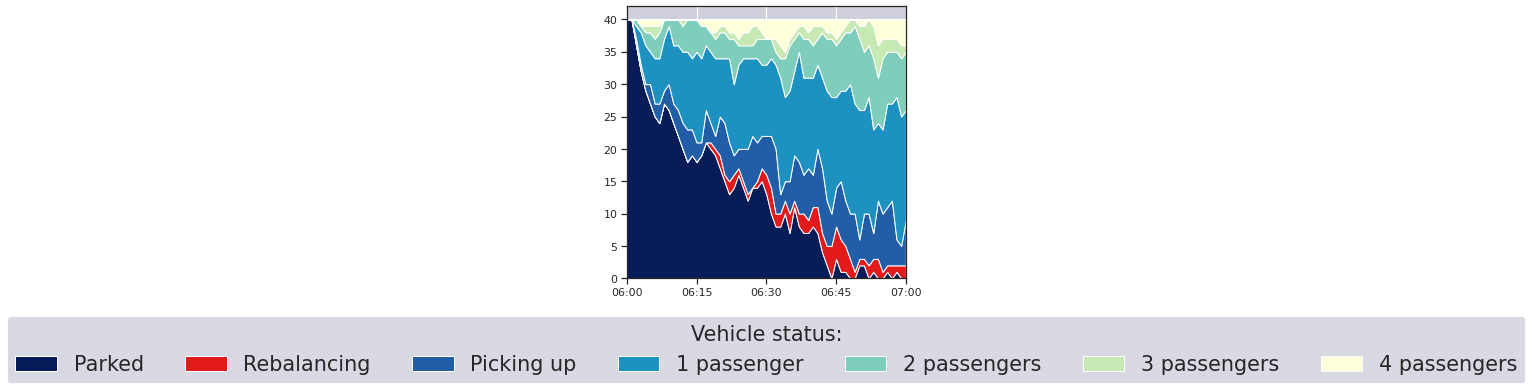

In [100]:
fig, ax = plt.subplots(1, figsize=(5,5))
graph_legend = ["Parked", "Rebalancing", "Picking up"] + ["1 passenger", "2 passengers", "3 passengers", "4 passengers"]

y = [df_filtered[c].tolist() for c in status_labels]

# Define limits of y (before smoothing)
ymin = 0
ymax = max(y)

# Smoth lines in y
if smooth:
    y = gaussian_filter1d(y, sigma=smooth)

font_config = {"fontsize": "xx-large",
        "fontsize_label": "xx-large",
        "fontsize_label_sr": "x-large",
        "context_font_scale": 1.3}

plt.stackplot(
    df.index,
    df["nOfVehiclesParked"] + df["nOfVehiclesDwellingInOrigin"], 
    df["nOfVehiclesRebalancing"],
    df["nOfVehiclesCruisingToPickup"],
    df["n_load_01"],
    df["n_load_02"],
    df["n_load_03"],
    df["n_load_04"],
    labels=graph_legend)
            
# Format legend
# Choosing palette. Source: https://seaborn.pydata.org/tutorial/color_palettes.html

sns.set_context('paper')
sns.set_style("ticks", {"xtick.major.size": 8, "axes.grid": True, 'axes.facecolor': '#d0d0dd', 'grid.color': '1.0'})
sns.set_context("notebook", font_scale=1)
print(sns.axes_style())

YlGnBu_r = ['#081d58', '#e31a1c', '#225ea8', '#1d91c0', '#7fcdbb', '#c7e9b4', '#ffffd9']
sns.set_palette(YlGnBu_r)

tw = 60
start_datetime, end_datetime = ('2019-02-20T06:00:00', '2019-02-20T07:00:00') 
x_min = datetime.strptime(start_datetime, '%Y-%m-%dT%H:%M:%S')
x_max = datetime.strptime(end_datetime, '%Y-%m-%dT%H:%M:%S')

range_dates = pd.date_range(start=x_min,
                            end=x_end,
                            freq="15T")

plt.xlim(range_dates[0], range_dates[-1])
plt.xticks(range_dates, [str(d.strftime("%H:%M")) for d in range_dates])
print(range_dates)


legend = plt.legend(loc="upper center",
                            bbox_to_anchor=(0.5, -0.1),
                            ncol=len(graph_legend),
                            fontsize=font_config["fontsize"],
                            edgecolor="white",
                            title="Vehicle status:")

        

legend.get_title().set_fontsize(font_config["fontsize_label"])  # legend 'Title' fontsize


In [66]:

    print(df.columns)
    print("Firt record:", df.iloc[0].name, " -- Last record:", df.iloc[-1].name)

    print("TW:", x_min, x_max)

#     # Number of requests
#     total_requests = df["n_requests"].sum()
#     time_ride_matching_s = df["time_ride_matching_s"].sum()
#     time_update_fleet_status_s = df["time_update_fleet_status_s"].sum()
#     time_vehicle_rebalancing_s = df["time_vehicle_rebalancing_s"].sum()

#     total_runtime = time_ride_matching_s + time_vehicle_rebalancing_s + time_vehicle_rebalancing_s
#     serviced = df["finished"][-1]
#     denied = df["denied"][-1]

    df.rename(columns={'nOfVehicles':'',
              'nOfVehiclesDwellingInOrigin':'origin_vehicles',
              'nOfVehiclesParked':'parked_vehicles',
              'nOfVehiclesRebalancing':'rebalancing',
              'nOfVehiclesServicingUsers': 'servicing',
              'nOfVehiclesCruisingToPickup':'picking_up'}, inplace=True)

plt.stackplot(df.index, df["nOfVehiclesParked"], df["nOfVehiclesRebalancing"], labels=['A','C'])

Index(['nOfVehicles', 'nOfVehiclesDwellingInOrigin', 'nOfVehiclesParked',
       'nOfVehiclesRebalancing', 'nOfVehiclesServicingUsers',
       'nOfVehiclesCruisingToPickup', 'distanceTraveledEmptyMeters',
       'distanceTraveledLoadedMeters', 'n_servicing_capacity_04',
       'n_servicing_capacity_02', 'n_load_00', 'n_load_01', 'n_load_02',
       'n_load_03', 'n_load_04'],
      dtype='object')
Firt record: 2019-02-20 06:01:00  -- Last record: 2019-02-20 08:00:00


NameError: name 'x_min' is not defined

In [60]:
day_config = {
        "custom_tw": ('2019-02-20T06:00:00', '2019-02-20T07:00:00'),
        "x_data_format": ('10T', '%#M'),
        "size_inches": (30, 9),
    }

fonts_large = {
        "fontsize": "xx-large",
        "fontsize_label": "xx-large",
        "fontsize_label_sr": "x-large",
        "context_font_scale": 1.3,
    }

input_dic = dict()
input_dic["max_capacity"] = 4
input_dic["simulation_time"] = 3600
input_dic["batch_duration"] = 60
input_dic["customer_segmentation"] = None
input_dic["service_rate"]= "NA"


plot_vehicle_status_graph(
    instance_folder,
    instance_folder,
    name_experiment,
    replace=True,
    smooth=0,
    label_y=([0, 10, 20, 30, 40, 60, 80, 100], [0, 10, 20, 30, 40, 60, 80, 100], "xx-large"),
    print_details=True,
    **fonts_large,
    **day_config,
    color_bg="#C0C0C0",
    horizontal_legend=True,
    day_sep_config=(
    dict(linewidth=6, color='white', alpha=0.4), dict(linewidth=1, color='black', linestyle='--')),
    fig_type='png',
    print_details_axis=("Time (h)", "#Vehicles"),
    input_dic=input_dic,
    show_tick_label_x=True,
    annotate_data_per_status=False,
    show_service_rate="Picked up: ",

)

Creating figure in '/mnt/d/projects/amodrl/src/test/data/round_track/VS_IN-TEST_SD-2019-02-20--06-00-00_ST-7200_TW-60_PR-0.100_IF-20(4)20(2)_MT-METHOD_OPTIMAL.png'
TW1(2019-02-20T06:00:00, 2019-02-20T07:00:00)
TW: ('2019-02-20T06:00:00', '2019-02-20T07:00:00')
TW2(2019-02-20T06:00:00, 2019-02-20T07:00:00)
Index(['nOfVehicles', 'nOfVehiclesDwellingInOrigin', 'nOfVehiclesParked',
       'nOfVehiclesRebalancing', 'nOfVehiclesServicingUsers',
       'nOfVehiclesCruisingToPickup', 'distanceTraveledEmptyMeters',
       'distanceTraveledLoadedMeters', 'n_servicing_capacity_04',
       'n_servicing_capacity_02', 'n_load_00', 'n_load_01', 'n_load_02',
       'n_load_03', 'n_load_04'],
      dtype='object')
Firt record: 2019-02-20 06:01:00  -- Last record: 2019-02-20 08:00:00
TW: 2019-02-20 06:00:00 2019-02-20 07:00:00
Len x: 61
{'axes.facecolor': '#d0d0dd', 'axes.edgecolor': '.15', 'axes.grid': True, 'axes.axisbelow': True, 'axes.labelcolor': '.15', 'figure.facecolor': 'white', 'grid.color': '1

<Figure size 2160x648 with 0 Axes>

<Figure size 2160x648 with 0 Axes>

In [19]:

    label_dict = {
    "nOfVehiclesParked":"parked_vehicles",
    }
    